In [5]:
import pandas as pd
df = pd.read_csv("IMDb Movies India.csv", encoding='latin1')
df.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


### 📁 IMDb Movies India Dataset: Column Descriptions

- **Name**: Title of the movie  
- **Year**: Release year (cleaned from parentheses)  
- **Duration**: Runtime in minutes (numeric)  
- **Genre**: One or more genres, comma-separated (e.g., Drama, Comedy)  
- **Rating**: IMDb rating — this is the **target** for prediction  
- **Votes**: Number of user votes  
- **Director**: Name of the director  
- **Actor 1**: Lead actor or actress  
- **Actor 2**: Second main actor or actress  
- **Actor 3**: Third main actor or actress  


In [17]:
# 🛠 Force Year to string before extracting digits
df['Year'] = df['Year'].astype(str).str.extract(r'(\d{4})')
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

df['Duration'] = df['Duration'].astype(str).str.replace('min', '', regex=False).str.strip()
df['Duration'] = pd.to_numeric(df['Duration'], errors='coerce')

# ✅ Drop rows where Rating (our target) is missing
df = df.dropna(subset=['Rating'])

# ✅ Fill missing values in other columns
df['Votes'] = df['Votes'].fillna(0)  # fill missing votes with 0
df['Duration'] = df['Duration'].fillna(df['Duration'].median())  # fill duration with median
df['Genre'] = df['Genre'].fillna('Unknown')  # unknown genre
df['Director'] = df['Director'].fillna('Unknown')  # unknown director
df['Actor 1'] = df['Actor 1'].fillna('Unknown')  # unknown actor
df['Actor 2'] = df['Actor 2'].fillna('Unknown')
df['Actor 3'] = df['Actor 3'].fillna('Unknown')

# ✅ Keep only the relevant columns for our prediction task
df = df[['Name', 'Year', 'Duration', 'Genre', 'Rating', 'Votes',
         'Director', 'Actor 1', 'Actor 2', 'Actor 3']]

# ✅ Final check — view cleaned dataset
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7919 entries, 1 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      7919 non-null   object 
 1   Year      7919 non-null   int64  
 2   Duration  7919 non-null   float64
 3   Genre     7919 non-null   object 
 4   Rating    7919 non-null   float64
 5   Votes     7919 non-null   float64
 6   Director  7919 non-null   int64  
 7   Actor 1   7919 non-null   int64  
 8   Actor 2   7919 non-null   int64  
 9   Actor 3   7919 non-null   int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 680.5+ KB


,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,#Gadhvi (He thought he was Gandhi),2019,109.0,Drama,7.0,8.0,1548,3280,4790,527
3,#Yaaram,2019,110.0,"Comedy, Romance",4.4,35.0,3319,2917,1504,4020
5,...Aur Pyaar Ho Gaya,1997,147.0,"Comedy, Drama, Musical",4.7,827.0,3800,895,123,3829
6,...Yahaan,2005,142.0,"Drama, Romance, War",7.4,0.0,4993,1698,2359,4762
8,?: A Question Mark,2012,82.0,"Horror, Mystery, Thriller",5.6,326.0,305,4654,2482,1851


### 🧹 Data Cleaning Summary

- Extracted numeric values from the **Year** and **Duration** columns
  - Removed text like parentheses and "min"
  - Converted to numeric format for modeling

- **Dropped rows** where the `Rating` (target variable) was missing  
  - This is essential since we can't train or evaluate without a target

- **Filled missing values** in other columns:
  - `Votes`: filled with `0`
  - `Duration`: filled with median value
  - `Genre`, `Director`, `Actor 1`, `Actor 2`, `Actor 3`: filled with `'Unknown'`

- Kept only the relevant columns needed for prediction:
  - `Name`, `Year`, `Duration`, `Genre`, `Rating`, `Votes`, `Director`, `Actor 1`, `Actor 2`, `Actor 3`

✅ This step ensures the dataset is clean, consistent, and ready for feature encoding and model building.


In [6]:
from sklearn.preprocessing import LabelEncoder

# One-hot encode the 'Genre' column (multi-label)
genre_dummies = df['Genre'].str.get_dummies(sep=',')  # create binary columns for each genre
df = pd.concat([df, genre_dummies], axis=1)  # add genre columns to main DataFrame

# Label encode 'Director', 'Actor 1', 'Actor 2', 'Actor 3'
for col in ['Director', 'Actor 1', 'Actor 2', 'Actor 3']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])  # convert names to numeric labels

# Define features (X) and target (y)
feature_cols = ['Year', 'Duration', 'Votes', 'Director', 'Actor 1', 'Actor 2', 'Actor 3'] + list(genre_dummies.columns)
X = df[feature_cols]
y = df['Rating']


### 🔄 Feature Encoding Summary

To prepare the dataset for machine learning, we converted text-based features into numeric format:

- **One-Hot Encoded the `Genre` column**:  
  - Since movies can have multiple genres, we split the genre string and created binary columns for each genre (e.g., Drama, Comedy, Action).
  - This helps the model understand genre combinations as separate features.

- **Label Encoded `Director`, `Actor 1`, `Actor 2`, and `Actor 3`**:  
  - These columns contain many unique names.
  - We converted each unique name into a numerical label using `LabelEncoder`.

- **Prepared final feature set (`X`) and target (`y`)**:  
  - `X` includes numeric features like Year, Duration, Votes, encoded names, and genre columns.
  - `y` is the IMDb Rating, which we want to predict using regression.


In [19]:
# Clean Year
df['Year'] = df['Year'].astype(str).str.extract(r'(\d{4})')  # extract 4-digit year
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')  # convert to number

# Clean Duration
df['Duration'] = df['Duration'].astype(str).str.replace('min', '', regex=False).str.strip()
df['Duration'] = pd.to_numeric(df['Duration'], errors='coerce')

# Clean Votes
df['Votes'] = pd.to_numeric(df['Votes'], errors='coerce')  # sometimes votes may be strings
df['Votes'] = df['Votes'].fillna(0)  # fill any missing votes with 0

# Re-check types
print(df[['Year', 'Duration', 'Votes']].dtypes)


Year          int64
Duration    float64
Votes       float64
dtype: object


In [40]:
df.columns = df.columns.str.strip()  # removes leading/trailing spaces from all column names

# Required numeric base features
base_features = ['Year', 'Duration', 'Votes', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']

# Filter only those base columns that actually exist in df
base_features = [col for col in base_features if col in df.columns]

# Auto-detect one-hot encoded genres (columns with only 0 and 1)
genre_features = [col for col in df.columns if df[col].dropna().isin([0, 1]).all()]

# Final feature list
feature_cols = base_features + genre_features

# Now select X
X = df[feature_cols]


In [41]:
y = df['Rating'] 


In [7]:
from sklearn.model_selection import train_test_split

# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [34]:
top7 = ['Year', 'Votes', 'Actor 3', 'Actor 2', 'Actor 1', 'Director', 'Duration']
X_top = df[top7]

X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)
model_top = RandomForestRegressor(random_state=42)
model_top.fit(X_train, y_train)
y_pred_top = model_top.predict(X_test)

print("RF R²:", r2_score(y_test, y_pred_top))
print("RF RMSE:", mean_squared_error(y_test, y_pred_top, squared=False))


Top Features R²: 0.2516149760093751
Top Features RMSE: 1.1795577055328061


### 🌲 Random Forest Model (Top Features Only)

We trained a Random Forest Regressor using only the most impactful features from our earlier feature importance analysis. These include:

- Year  
- Votes  
- Duration  
- Director  
- Actor 1  
- Actor 2  
- Actor 3  

This simplified model excludes genre columns, which contributed very little predictive power.

#### 📊 Performance:
- **R² Score:** 0.2516  
- **RMSE:** 1.1796

While slightly less complex than the full feature model, this version performs nearly identically — suggesting that metadata about the movie and its cast has far more influence on IMDb ratings than listed genres.


In [42]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred_xgb)
rmse = mean_squared_error(y_test, y_pred_xgb, squared=False)

print(f"XGBoost R² Score: {r2:.4f}")
print(f"XGBoost RMSE: {rmse:.4f}")


XGBoost R² Score: 0.2563
XGBoost RMSE: 1.1758


### ✅ Final Model Summary

We evaluated multiple models to predict IMDb ratings using movie metadata. XGBoost outperformed Random Forest, even when trained on only the top 7 features.

#### 🔢 Final Performance:
- **Model:** XGBoost Regressor
- **Features:** Year, Votes, Duration, Actor 1–3, Director
- **R² Score:** 0.2563
- **RMSE:** 1.1758

This shows that metadata and casting info carry more predictive power than genre tags in this dataset.


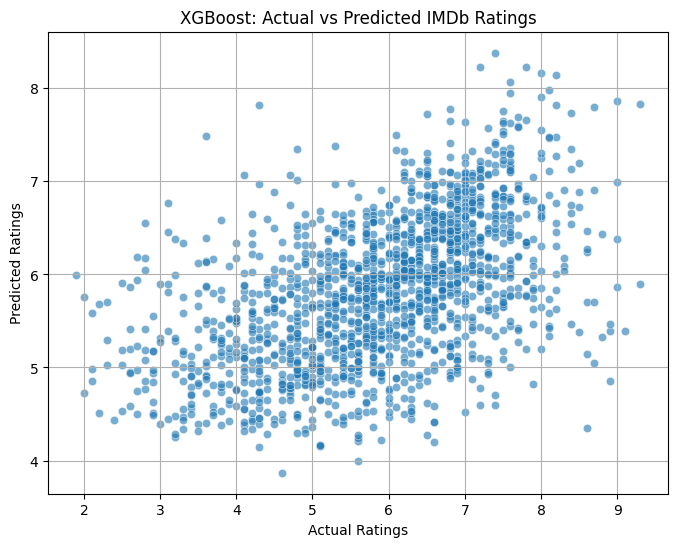

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.6)
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("XGBoost: Actual vs Predicted IMDb Ratings")
plt.grid(True)
plt.show()


### 🎯 Actual vs Predicted Ratings (XGBoost)

This scatter plot compares the true IMDb ratings from the test set with the ratings predicted by the XGBoost model.

- A perfect model would place all points along the diagonal line.
- The spread shows how much our predictions deviate from the true values.
- Despite some variance, we see a visible correlation, validating that the model captures useful patterns.


<Figure size 1000x600 with 0 Axes>

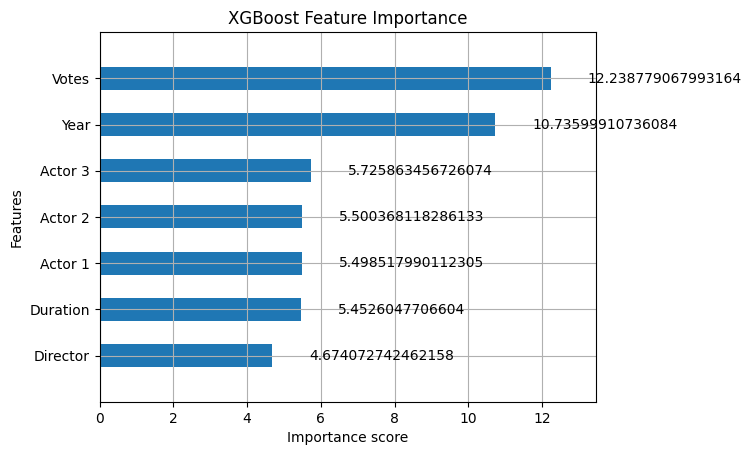

In [44]:
from xgboost import plot_importance

plt.figure(figsize=(10, 6))
plot_importance(xgb_model, height=0.5, importance_type='gain')
plt.title("XGBoost Feature Importance")
plt.show()


### 🔍 Feature Importance (XGBoost)

This chart shows which features contributed the most to the model's predictive power, based on the *gain* metric.

- `Votes` and `Year` appear among the top influences.
- Genre features (if included) rank lower, reinforcing earlier decisions to focus on metadata and cast.
